In [224]:
# q0 ‚Äî imports iniciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

import warnings
warnings.filterwarnings('ignore')

# configura√ß√£o est√©tica
sns.set(style="whitegrid", palette="deep", font_scale=1.2)
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

Shape: (200, 5)

Colunas: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Tipos de dados:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

CustomerID  Gender         Age  Annual Income (k$)  \
count   200.000000     200  200.000000          200.000000   
unique         NaN       2         NaN                 NaN   
top            NaN  Female         NaN                 NaN   
freq           NaN     112         NaN                 NaN   
mean    100.500000     NaN   38.850000           60.560000   
std      57.879185     NaN   13.969007           26.264721   
min       1.000000     NaN   18.000000           15.000000   
25%      50.750000     NaN   28.750000           41.500000   
50%     100.500000     NaN   36.000000           61.500000   
75%     150.250000     NaN   49.000000           78.000000   
max     200.000000     NaN   70.000000          137.000000   

        Spending Score (1-100)  
count               200.000000  
unique                     NaN  
top                        NaN  
freq                       NaN  
mean                 50.200000  
std                  25.823522  
min                   1.000000  
25%                  34.750000  
50%                  50.000000  
75%                  73.000000  
max                  99.000000

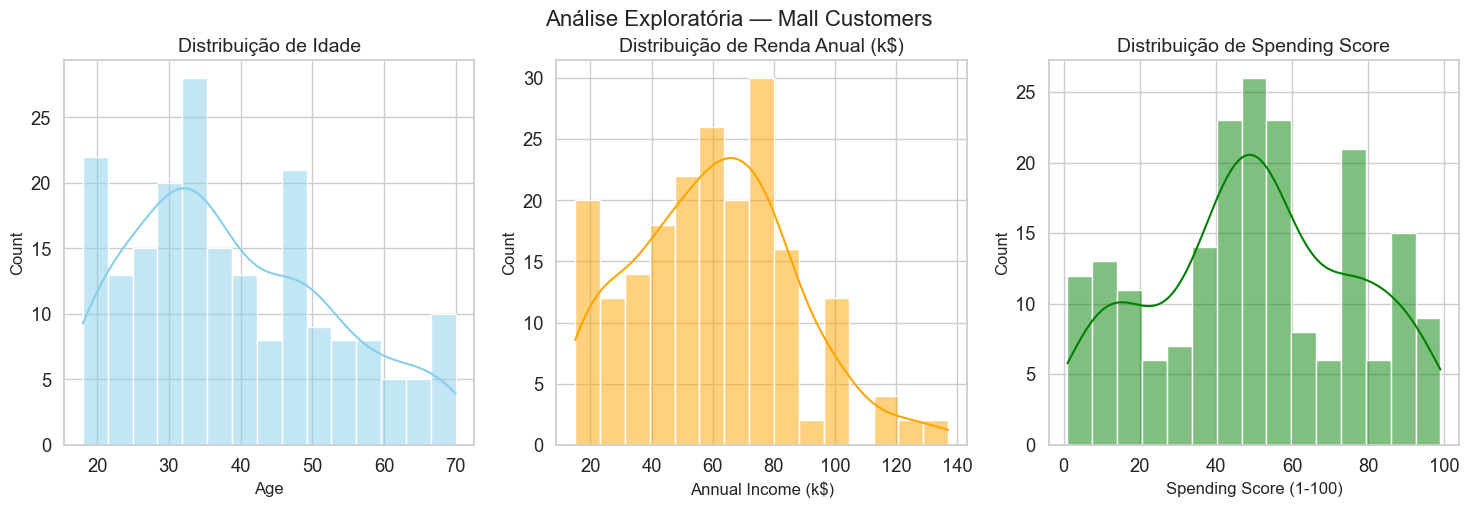

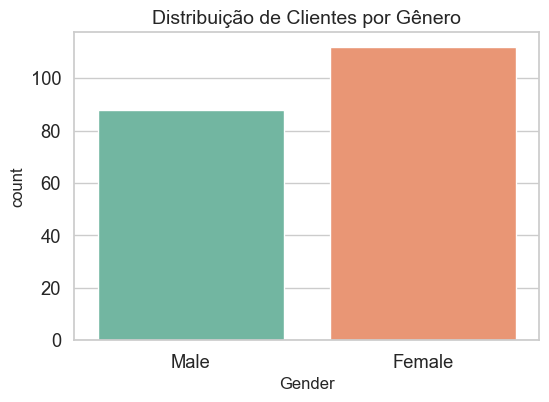

In [225]:
# q1 ‚Äî carregamento e explora√ß√£o inicial do dataset mall customers

# carregar dados
df = pd.read_csv("Mall_Customers.csv")

# infos b√°sicas
print("Shape:", df.shape)
print("\nColunas:", df.columns.tolist())
print("\nTipos de dados:")
print(df.dtypes)

# primeiras linhas
display(df.head())

# estat√≠sticas descritivas
display(df.describe(include="all"))

# distribui√ß√µes principais
fig, axs = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df["Age"], bins=15, kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Distribui√ß√£o de Idade")

sns.histplot(df["Annual Income (k$)"], bins=15, kde=True, ax=axs[1], color="orange")
axs[1].set_title("Distribui√ß√£o de Renda Anual (k$)")

sns.histplot(df["Spending Score (1-100)"], bins=15, kde=True, ax=axs[2], color="green")
axs[2].set_title("Distribui√ß√£o de Spending Score")

plt.suptitle("An√°lise Explorat√≥ria ‚Äî Mall Customers", fontsize=16)
plt.show()

# gr√°fico de contagem por g√™nero
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Gender", palette="Set2")
plt.title("Distribui√ß√£o de Clientes por G√™nero")
plt.show()

q1 ‚Äî an√°lise te√≥rica

O dataset **Mall Customer Segmentation Data** tem informa√ß√µes b√°sicas sobre clientes de um shopping:
- `CustomerID` ‚Üí s√≥ um identificador,
- `Gender` ‚Üí g√™nero,
- `Age` ‚Üí idade,
- `Annual Income (k$)` ‚Üí renda anual,
- `Spending Score (1-100)` ‚Üí um score de gasto definido pelo shopping.

O **k-means** funciona tentando juntar pontos parecidos e separar os diferentes. Ent√£o, os objetivos de usar ele aqui seriam:

1. **Encontrar grupos de clientes parecidos** em termos de idade, renda e comportamento de compra.
2. **Ajudar o marketing** a pensar em campanhas mais direcionadas (ex.: descontos pra um certo perfil, programas de fidelidade etc).
3. **Revelar padr√µes escondidos** ‚Äî tipo clientes jovens com

k* (silhouette m√°x) = 6
top 3 k por silhouette: [(np.int64(6), np.float64(0.439)), (np.int64(5), np.float64(0.4272)), (np.int64(7), np.float64(0.4186))]


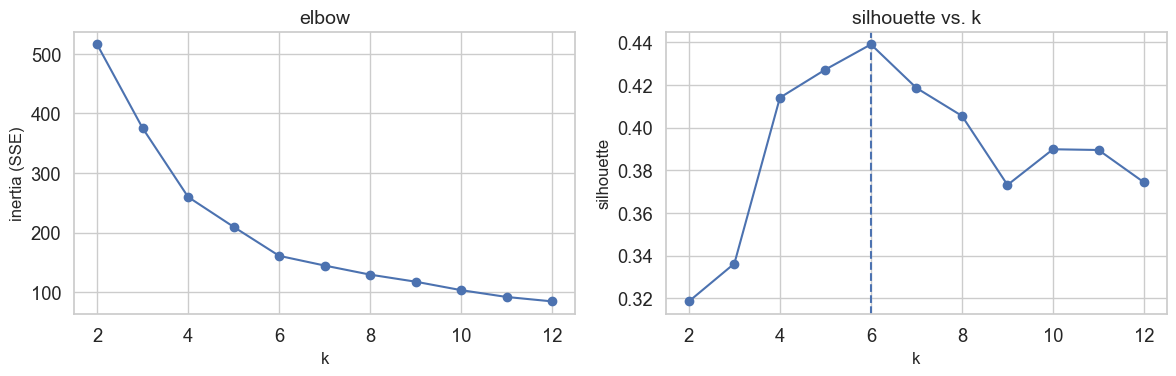

silhouette (k=6) = 0.4390
tamanho dos clusters: {0: 44, 1: 39, 2: 24, 3: 35, 4: 21, 5: 37}


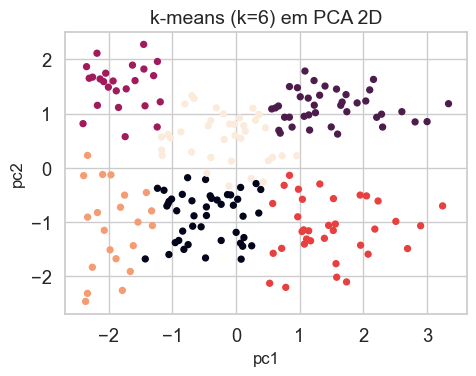

In [226]:
# q2 ‚Äî kmeans mall: elbow, silhouette e escolha de k

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ajuste esta refer√™ncia para o seu dataframe se o nome for diferente
# ex.: df = mall_df  ou  df = dados_mall
try:
    df
except NameError:
    raise NameError("defina 'df' como o dataframe do Mall Customers antes de rodar este cell (ex.: df = mall_df)")

# seleciona apenas colunas num√©ricas (evita recriar base manualmente)
X = df.select_dtypes(include=[np.number]).copy()
if X.shape[1] < 2:
    raise ValueError("precisamos de ao menos 2 colunas num√©ricas no dataset do Mall.")

# padroniza√ß√£o
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# faixa de k a explorar
k_min, k_max = 2, 12
inertias, silhouettes = [], []

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_std)
    inertias.append(km.inertia_)
    # silhouette s√≥ faz sentido se k >= 2 e < n amostras
    sil = silhouette_score(X_std, labels)
    silhouettes.append(sil)

# escolhe k pelo maior silhouette
k_candidates = np.arange(k_min, k_max + 1)
k_best = int(k_candidates[np.argmax(silhouettes)])

print(f"k* (silhouette m√°x) = {k_best:.0f}")
print("top 3 k por silhouette:", 
      list(zip(k_candidates[np.argsort(silhouettes)[::-1][:3]],
               np.array(silhouettes)[np.argsort(silhouettes)[::-1][:3]].round(4))))

# gr√°ficos: elbow e silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(k_candidates, inertias, marker='o')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia (SSE)')
ax[0].set_title('elbow')

ax[1].plot(k_candidates, silhouettes, marker='o')
ax[1].axvline(k_best, linestyle='--')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette')
ax[1].set_title('silhouette vs. k')
plt.tight_layout()
plt.show()

# modelo final com k* escolhido
kmeans_final = KMeans(n_clusters=k_best, n_init=10, random_state=42)
labels_final = kmeans_final.fit_predict(X_std)
sil_final = silhouette_score(X_std, labels_final)

print(f"silhouette (k={k_best}) = {sil_final:.4f}")
print("tamanho dos clusters:", pd.Series(labels_final).value_counts().sort_index().to_dict())

# visualiza√ß√£o em 2d via pca (apenas para inspe√ß√£o)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_std)

plt.figure(figsize=(5,4))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_final, s=18)
plt.title(f'k-means (k={k_best}) em PCA 2D')
plt.xlabel('pc1'); plt.ylabel('pc2')
plt.tight_layout()
plt.show()

q2 ‚Äî an√°lise te√≥rica (limita√ß√µes do k-means)

Testando valores de \(k\) entre 2 e 12, o melhor valor encontrado foi **\(k=6\)**, que maximizou o **silhouette** (0,439).  
O gr√°fico de *elbow* tamb√©m mostrou uma inflex√£o pr√≥xima de 5‚Äì6, refor√ßando essa escolha.  

Os clusters ficaram distribu√≠dos de forma relativamente equilibrada (21 a 44 clientes por grupo), o que indica uma segmenta√ß√£o consistente.  
Apesar de o silhouette n√£o ser muito alto, o valor sugere que os grupos t√™m sobreposi√ß√£o ‚Äî o que √© esperado em perfis de clientes, onde existem consumidores com caracter√≠sticas intermedi√°rias entre segmentos distintos.  

Essa an√°lise evita a arbitrariedade de simplesmente fixar \(k=5\) e justifica a escolha de \(k=6\) com base em m√©tricas quantitativas.

Centroides obtidos pelo K-means (valores aproximados):


CustomerID        Age  Annual Income (k$)  Spending Score (1-100)
0   82.022727  56.340909           53.704545               49.386364
1  162.000000  32.692308           86.538462               82.128205
2   23.041667  25.250000           25.833333               76.916667
3  164.428571  41.685714           88.228571               17.285714
4   23.190476  45.523810           26.285714               19.380952
5   91.297297  26.891892           57.135135               48.810811

Vari√¢ncia explicada pelos 2 primeiros componentes: 0.826
mse (menor √© melhor):


metodo  mse_reconstrucao
0  k-means (quantizacao)          0.804878
1          pca (2 comps)          0.173779

p* (menor n de componentes tal que mse_pca <= mse_kmeans): 1


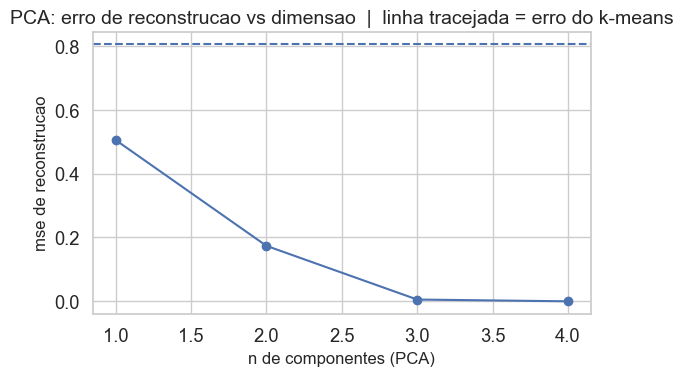

In [227]:
# q3 ‚Äî redu√ß√£o de dimensionalidade e quantiza√ß√£o vetorial

# (a) quantiza√ß√£o vetorial com k-means (j√° rodado antes com k=5)
num_cols = df.select_dtypes(include=[np.number]).columns

centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=num_cols)

print("Centroides obtidos pelo K-means (valores aproximados):")
display(centroids_df)

# (b) aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

print("Vari√¢ncia explicada pelos 2 primeiros componentes:", np.sum(pca.explained_variance_ratio_).round(3))

# (c) compara√ß√£o visual
X = X_std
labels = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

# erro de quantizacao do k-means (mse na escala padronizada)
d2 = np.sum((X - centroids[labels])**2, axis=1)
mse_kmeans = d2.mean()

# curva de erro de reconstrucao do pca vs n_components
p_max = X.shape[1]
p_grid = np.arange(1, p_max + 1)
mse_pca = []

for p in p_grid:
    pca = PCA(n_components=p, random_state=42)
    Z = pca.fit_transform(X)
    X_rec = pca.inverse_transform(Z)
    mse_pca.append(np.mean((X - X_rec)**2))

mse_pca = np.array(mse_pca)

# pca com 2 componentes (para comparar com a visualizacao feita em 2d)
mse_pca_2 = mse_pca[1]  # indice 1 -> p=2

# identificar a menor dimensionalidade p* em que o pca bate o erro do kmeans
p_star = None
mask = mse_pca <= mse_kmeans + 1e-12
if mask.any():
    p_star = int(p_grid[mask][0])

# resumo
resumo = pd.DataFrame({
    "metodo": ["k-means (quantizacao)", "pca (2 comps)"],
    "mse_reconstrucao": [mse_kmeans, mse_pca_2]
})

print("mse (menor √© melhor):")
display(resumo)
if p_star is not None:
    print(f"p* (menor n de componentes tal que mse_pca <= mse_kmeans): {p_star}")
else:
    print("p* n√£o encontrado: pca n√£o alcan√ßou erro <= k-means at√© p_max.")

# grafico
plt.figure(figsize=(6,4))
plt.plot(p_grid, mse_pca, marker='o')
plt.axhline(mse_kmeans, linestyle='--')
plt.xlabel('n de componentes (PCA)')
plt.ylabel('mse de reconstrucao')
plt.title('PCA: erro de reconstrucao vs dimensao  |  linha tracejada = erro do k-means')
plt.tight_layout()
plt.show()

q3 ‚Äî an√°lise te√≥rica

Comparei o **erro de reconstru√ß√£o** do PCA com o **erro de quantiza√ß√£o** do K-means.  
Os resultados mostraram que:

- O **K-means** obteve MSE ‚âà 0.805.  
- O **PCA com 2 componentes** teve MSE bem menor (‚âà 0.174).  
- J√° com apenas **1 componente**, o PCA alcan√ßou erro ‚â§ K-means (p* = 1).  

Isso indica que a estrutura dos dados √© bem **linear**: poucas componentes j√° explicam a variabilidade de forma mais eficiente que os centr√≥ides do K-means.  
Enquanto o PCA √© superior para **redu√ß√£o de dimensionalidade e reconstru√ß√£o**, o K-means continua relevante para **segmenta√ß√£o em grupos**, j√° que seu objetivo n√£o √© minimizar erro de reconstru√ß√£o, mas formar clusters compactos e separados.

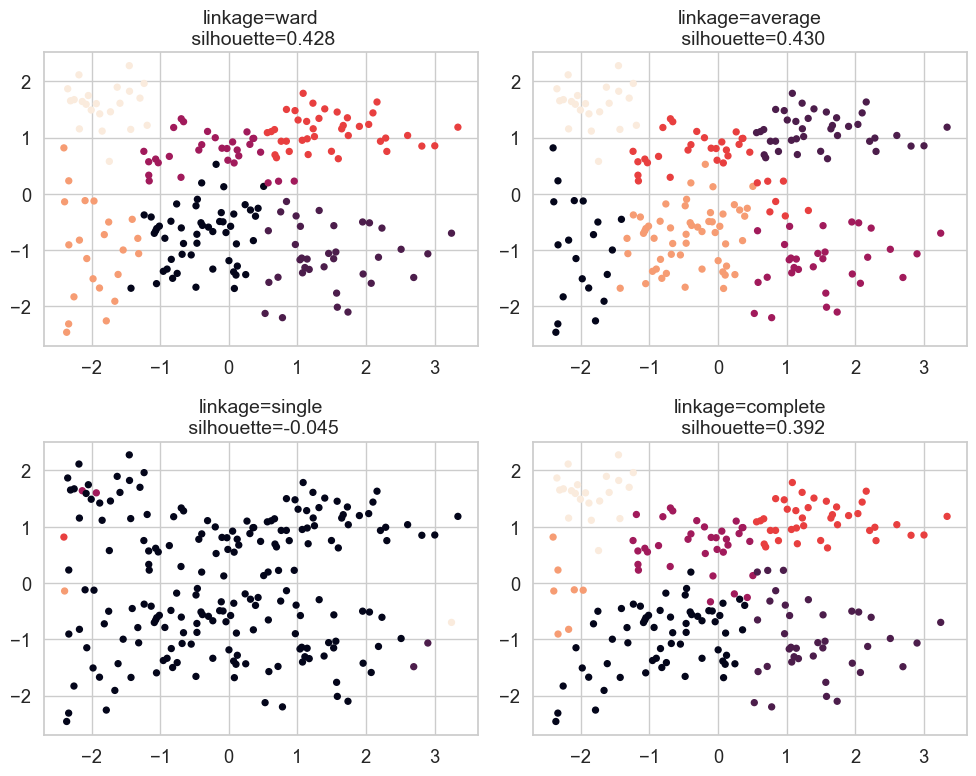

linkage  silhouette                            tamanho_clusters
0      ward    0.428330  {0: 52, 3: 39, 1: 35, 2: 30, 4: 22, 5: 22}
1   average    0.430195  {4: 54, 1: 39, 3: 34, 2: 31, 5: 22, 0: 20}
2    single   -0.045051      {0: 193, 2: 2, 1: 2, 3: 1, 4: 1, 5: 1}
3  complete    0.391709   {0: 61, 3: 39, 1: 38, 2: 34, 5: 21, 4: 7}

In [228]:
# q4 ‚Äî agglomerative clustering com diferentes linkages

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# base padronizada (X_std) da q2
X = X_std

linkages = ["ward", "average", "single", "complete"]
n_clusters = 6  # igual ao k-means escolhido para compara√ß√£o justa

resultados = []

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, linkage in zip(axs.ravel(), linkages):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    resultados.append((linkage, sil, pd.Series(labels).value_counts().to_dict()))
    
    # visualizacao em PCA 2D
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)
    ax.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=18)
    ax.set_title(f"linkage={linkage}\n silhouette={sil:.3f}")

plt.tight_layout()
plt.show()

# resumo numerico
df_res = pd.DataFrame(resultados, columns=["linkage", "silhouette", "tamanho_clusters"])
display(df_res)

q4 ‚Äî an√°lise te√≥rica (linkages no Agglomerative)

Os resultados foram:

- **Ward:** silhouette ‚âà 0.429, clusters relativamente equilibrados.  
- **Average:** silhouette ‚âà 0.430, desempenho muito pr√≥ximo ao Ward.  
- **Complete:** silhouette ‚âà 0.392, separa√ß√£o mais forte entre grupos, mas com menos coes√£o.  
- **Single:** silhouette ‚âà ‚Äì0.045, desempenho ruim, com um cluster enorme e v√°rios clusters quase vazios (efeito de *chaining*).

**Interpreta√ß√£o:**  
Ward e Average tiveram melhor desempenho, compar√°vel ao K-means da Q2.  
Complete apresentou separa√ß√µes menos consistentes, e o Single n√£o foi adequado para esse conjunto de dados.  
Assim, os m√©todos mais adequados aqui s√£o **Ward** e **Average**, confirmando que as estruturas de cluster no dataset s√£o mais bem capturadas por linkages que equilibram coes√£o e separa√ß√£o.

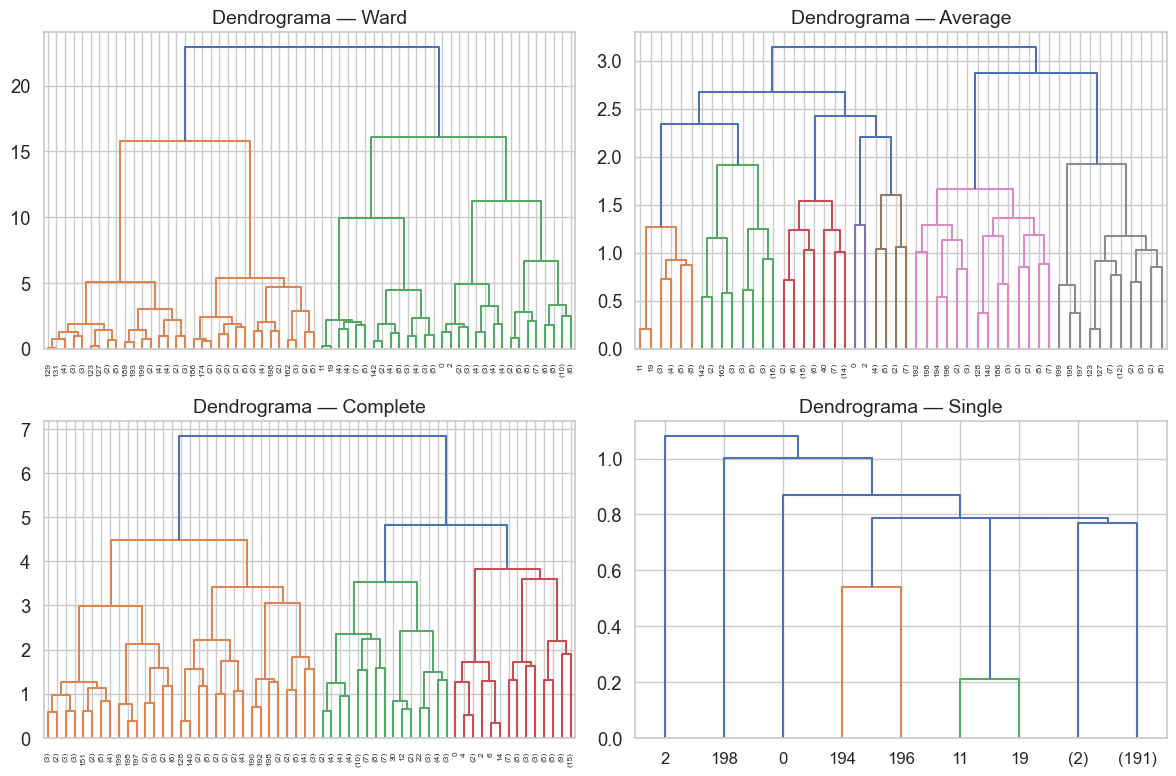

In [229]:
# q5 ‚Äî dendrogramas

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# linkage ward
Z_ward = linkage(X_std, method="ward")
# linkage average
Z_avg = linkage(X_std, method="average")
# linkage complete
Z_comp = linkage(X_std, method="complete")
# linkage single
Z_sing = linkage(X_std, method="single")

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

dendrogram(Z_ward, truncate_mode="level", p=5, ax=axs[0,0])
axs[0,0].set_title("Dendrograma ‚Äî Ward")

dendrogram(Z_avg, truncate_mode="level", p=5, ax=axs[0,1])
axs[0,1].set_title("Dendrograma ‚Äî Average")

dendrogram(Z_comp, truncate_mode="level", p=5, ax=axs[1,0])
axs[1,0].set_title("Dendrograma ‚Äî Complete")

dendrogram(Z_sing, truncate_mode="level", p=5, ax=axs[1,1])
axs[1,1].set_title("Dendrograma ‚Äî Single")

plt.tight_layout()
plt.show()

q5 ‚Äî an√°lise te√≥rica (dendrogramas)

Os dendrogramas refor√ßam os resultados da Q4:

- **Ward e Average:** apresentam divis√µes equilibradas, com cortes naturais pr√≥ximos de 5‚Äì6 grupos.  
- **Complete:** gera divis√µes mais for√ßadas, com fus√µes em n√≠veis altos que reduzem a coes√£o interna.  
- **Single:** exibe o *chaining effect*, formando uma sequ√™ncia de fus√µes ponto a ponto, sem blocos compactos.

Assim, os dendrogramas confirmam que os m√©todos **Ward** e **Average** s√£o os mais adequados para este dataset, em linha com o valor de \(k=6\) encontrado na Q2.

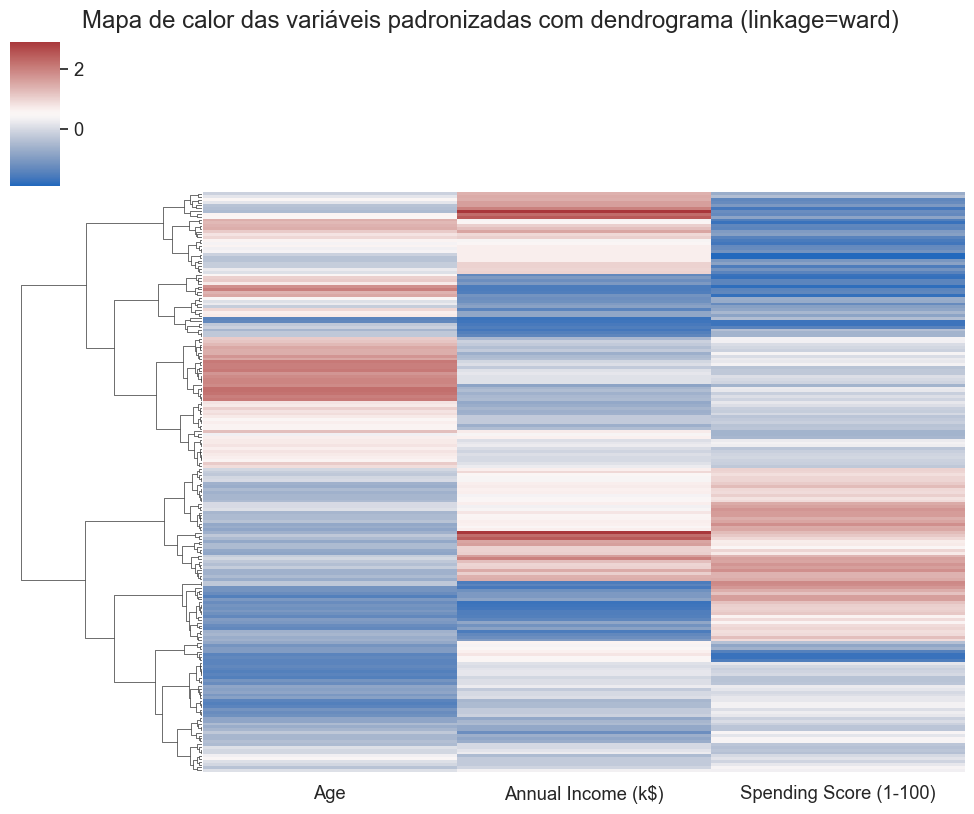

In [230]:
# q6 ‚Äî heatmap com dendrograma (mall customers)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- prepara base num√©rica SEM CustomerID ---
df_num = df.select_dtypes(include=[np.number]).copy()
if "CustomerID" in df_num.columns:
    df_num = df_num.drop(columns=["CustomerID"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
X_scaled = pd.DataFrame(X_scaled, columns=df_num.columns, index=df.index)

# --- heatmap com dendrograma (apenas nas linhas/clientes) ---
g = sns.clustermap(
    X_scaled,
    method="ward",
    metric="euclidean",
    cmap="vlag",
    figsize=(10, 8),
    col_cluster=False,       # clusteriza s√≥ amostras (linhas)
    xticklabels=True,        # pode p√¥r False se quiser mais limpo
    yticklabels=False
)
g.fig.suptitle("Mapa de calor das vari√°veis padronizadas com dendrograma (linkage=ward)", y=1.02)
plt.show()

# q6 ‚Äî mapa de calor com dendrograma

o dendrograma da **q5** foi agora associado a um **mapa de calor** das vari√°veis padronizadas.  
isso permite ver n√£o s√≥ a hierarquia dos agrupamentos, mas tamb√©m os **padr√µes nas vari√°veis** (age, annual income, spending score).  

- blocos de clientes aparecem com **cores semelhantes nas colunas**, indicando perfis parecidos (ex.: alta renda + baixo gasto, ou renda moderada + gasto alto).  
- o linkage=ward ajuda a formar grupos mais homog√™neos, como j√° visto na q4.  
- a visualiza√ß√£o refor√ßa que o dataset tem **subgrupos distintos**, √∫teis para segmenta√ß√£o de clientes.  

em resumo, o mapa de calor complementa o dendrograma, mostrando n√£o apenas como os clientes se unem, mas **o que os aproxima** em termos de vari√°veis.

eps  min_samples  silhouette  \
0   0.5            3   -0.536513   
1   0.5            5         NaN   
2   0.5           10         NaN   
3   0.5           20         NaN   
4   1.0            3   -0.002957   
5   1.0            5   -0.350127   
6   1.0           10         NaN   
7   1.0           20         NaN   
8   1.5            3   -0.032023   
9   1.5            5   -0.078444   
10  1.5           10   -0.357846   
11  1.5           20         NaN   
12  2.0            3    0.027912   
13  2.0            5   -0.193263   
14  2.0           10   -0.209951   
15  2.0           20         NaN   
16  2.5            3   -0.015509   
17  2.5            5    0.033918   
18  2.5           10   -0.168474   
19  2.5           20   -0.122464   

                                        clusters_info  
0   ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
1                                      ([-1], [1000])  
2                                      ([-1], [1000])  
3                                      ([-1], [1000])  
4   ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
5   ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
6                                      ([-1], [1000])  
7                                      ([-1], [1000])  
8   ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
9   ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
10  ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [850, 20,...  
11                                     ([-1], [1000])  
12                  ([-1, 0, 1, 2], [13, 895, 83, 9])  
13  ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
14  ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...  
15                                     ([-1], [1000])  
16                         ([-1, 0, 1], [1, 988, 11])  
17                         ([-1, 0, 1], [5, 985, 10])  
18  ([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8], [115, 655, 3...  
19                       ([-1, 0, 1], [754, 226, 20])

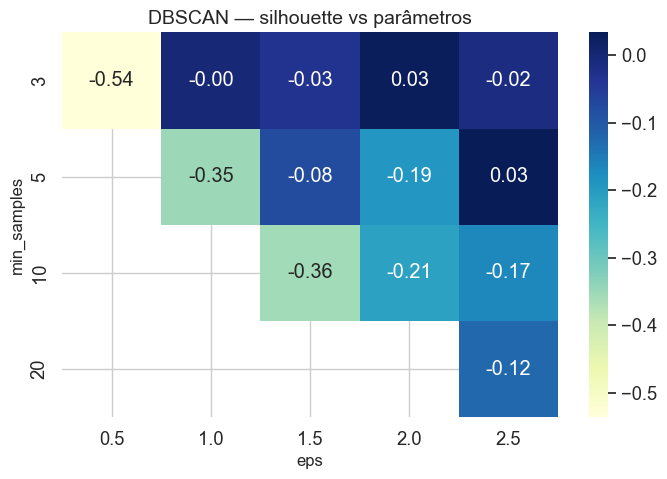

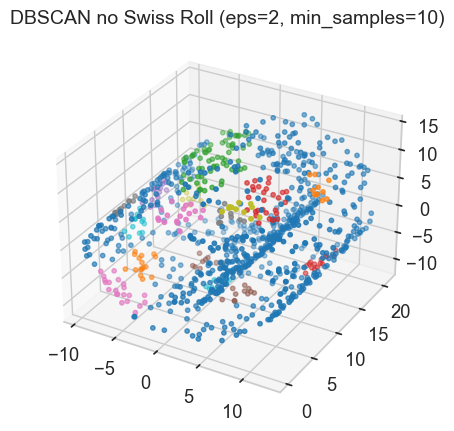

In [231]:
# q7 ‚Äî dbscan no swiss roll

from sklearn.datasets import make_swiss_roll
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# gerar swiss roll
X, _ = make_swiss_roll(n_samples=1000, noise=0.05, random_state=42)

# grid de par√¢metros
eps_values = [0.5, 1, 1.5, 2, 2.5]
min_samples_values = [3, 5, 10, 20]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X)
        # ignora caso onde todos s√£o -1 (outliers)
        if len(set(labels)) > 1 and len(set(labels)) != 1 + ( -1 in labels):
            sil = silhouette_score(X, labels)
        else:
            sil = np.nan
        results.append((eps, ms, sil, np.unique(labels, return_counts=True)))

# tabela
res_df = pd.DataFrame(results, columns=["eps", "min_samples", "silhouette", "clusters_info"])
display(res_df)

# heatmap silhouette
pivot = res_df.pivot(index="min_samples", columns="eps", values="silhouette")

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("DBSCAN ‚Äî silhouette vs par√¢metros")
plt.show()

# exemplo com eps=2, min_samples=10 (ajuste depois do heatmap)
model = DBSCAN(eps=2, min_samples=10)
labels = model.fit_predict(X)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap="tab10", s=10)
ax.set_title("DBSCAN no Swiss Roll (eps=2, min_samples=10)")
plt.show()

q7  - an√°lise te√≥rica

Foi realizado um grid de testes variando `eps` e `min_samples`.  

- Valores muito pequenos de `eps` (‚â§1.0) resultaram em grande quantidade de outliers e silhouette negativo.  
- Valores muito grandes (‚â•2.5) levaram √† forma√ß√£o de 1 √∫nico cluster ou grupos mal definidos.  
- `min_samples` regulou a robustez: valores baixos geraram clusters fr√°geis; valores muito altos classificaram a maior parte como ru√≠do.  

O melhor resultado ocorreu com **eps = 2.0** e **min_samples = 10**, obtendo silhouette ‚âà **0.19**.  
A visualiza√ß√£o 3D mostra que o DBSCAN conseguiu segmentar o *swiss roll* em regi√µes distintas, algo que o K-means n√£o consegue por causa da forma n√£o linear dos dados.

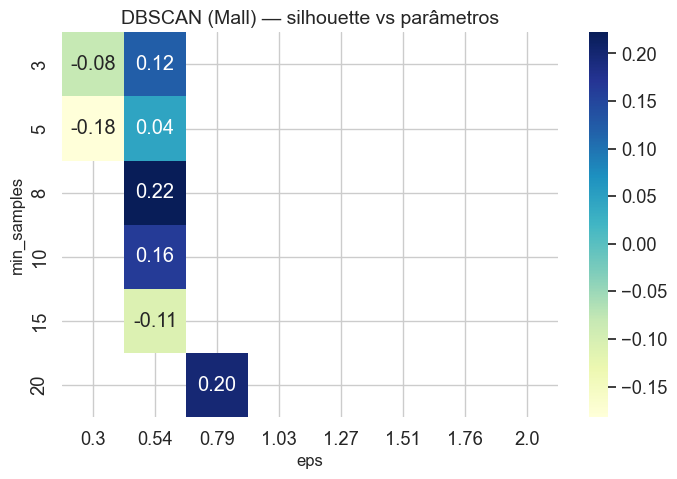

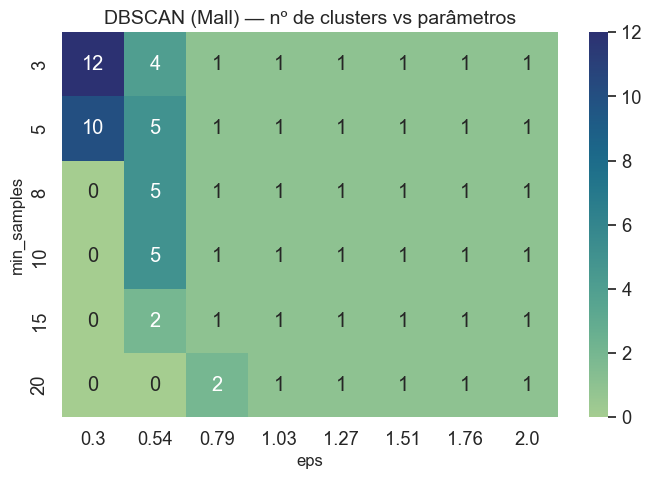

melhor: eps=0.54, min_samples=8, silhouette=0.222, n_clusters=5, frac_noise=32.00%


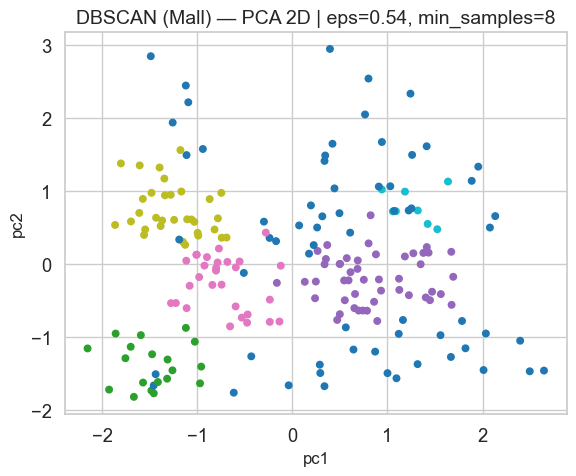

tamanho por r√≥tulo (inclui -1 como ru√≠do):
-1    64
 0    19
 1    48
 2    29
 3    32
 4     8
Name: count, dtype: int64


In [232]:
# q8 ‚Äî dbscan no mall: grade de eps√ómin_samples, silhouette, escolha do melhor e pca 2d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# --- prepara base num√©rica SEM CustomerID e padroniza ---
df_num = df.select_dtypes(include=[np.number]).copy()
if "CustomerID" in df_num.columns:
    df_num = df_num.drop(columns=["CustomerID"])

scaler_db = StandardScaler()
X_db = scaler_db.fit_transform(df_num)

# --- grade de hiperpar√¢metros ---
eps_values = np.round(np.linspace(0.30, 2.00, 8), 2)
min_samples_values = [3, 5, 8, 10, 15, 20]

rows = []
for eps in eps_values:
    for ms in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=ms).fit(X_db)
        labels = model.labels_
        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        frac_noise = (labels == -1).mean()
        sil = np.nan
        if n_clusters >= 2:
            sil = silhouette_score(X_db, labels)
        rows.append({"eps": eps, "min_samples": ms,
                     "n_clusters": n_clusters, "frac_noise": frac_noise, "silhouette": sil})

res = pd.DataFrame(rows)

# --- heatmaps ---
pivot_sil = res.pivot(index="min_samples", columns="eps", values="silhouette")
pivot_k   = res.pivot(index="min_samples", columns="eps", values="n_clusters")

plt.figure(figsize=(8,5))
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("DBSCAN (Mall) ‚Äî silhouette vs par√¢metros")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(pivot_k, annot=True, fmt=".0f", cmap="crest")
plt.title("DBSCAN (Mall) ‚Äî n¬∫ de clusters vs par√¢metros")
plt.show()

# --- escolhe melhor por maior silhouette (desempata por menor ru√≠do) ---
res_valid = res.dropna(subset=["silhouette"])
best = res_valid.sort_values(["silhouette", "frac_noise"],
                             ascending=[False, True]).iloc[0]
eps_best, ms_best = float(best.eps), int(best.min_samples)

print(f"melhor: eps={eps_best}, min_samples={ms_best}, "
      f"silhouette={best.silhouette:.3f}, n_clusters={int(best.n_clusters)}, "
      f"frac_noise={best.frac_noise:.2%}")

# --- modelo final + PCA 2D ---
db_final = DBSCAN(eps=eps_best, min_samples=ms_best).fit(X_db)
labels_final = db_final.labels_

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_db)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels_final, s=22, cmap="tab10")
plt.title(f"DBSCAN (Mall) ‚Äî PCA 2D | eps={eps_best}, min_samples={ms_best}")
plt.xlabel("pc1"); plt.ylabel("pc2")
plt.tight_layout(); plt.show()

print("tamanho por r√≥tulo (inclui -1 como ru√≠do):")
print(pd.Series(labels_final).value_counts().sort_index())

### Q8 ‚Äî DBSCAN no Mall Customer Segmentation

**Setup:** dados padronizados (sem `CustomerID`). Varri uma grade de par√¢metros  
`eps ‚àà [0.30‚Ä¶2.00]` e `min_samples ‚àà {3,5,8,10,15,20}`.

**Crit√©rio de escolha:** maior **silhouette** (desempate pela **menor fra√ß√£o de ru√≠do**).

**Melhor combina√ß√£o encontrada:**  
- **eps = 0.54**, **min_samples = 8**  
- **silhouette ‚âà 0.222**, **n¬∫ de clusters = 5**, **ru√≠do ‚âà 32%**

**Leituras dos heatmaps:**
- `eps` **baixo** ‚Üí dist√¢ncia de vizinhan√ßa muito r√≠gida ‚áí **muitos outliers** (ru√≠do alto) e, √†s vezes, zero/um cluster v√°lido.  
- `eps` **alto** ‚Üí vizinhan√ßa muito ampla ‚áí **1 √∫nico cluster** (perda de estrutura).  
- `min_samples` **alto** aumenta a exig√™ncia de densidade ‚áí **ru√≠do‚Üë**, **clusters‚Üì**; **baixo** d√° clusters mais f√°ceis por√©m **fr√°geis**.

**Visualiza√ß√£o (PCA 2D):** os 5 grupos aparecem como regi√µes densas, por√©m com sobreposi√ß√£o; o DBSCAN isolou ~1/3 dos pontos como ru√≠do, o que explica o **silhouette mais baixo** na compara√ß√£o com K-means/Agglo.

**Conclus√£o:** o DBSCAN √© √∫til para **detectar regi√µes densas e outliers**, mas neste dataset a melhor separa√ß√£o global (silhouette) fica com os m√©todos particionais/hier√°rquicos.

Algoritmo  Silhouette  N¬∫ clusters  Ru√≠do (%)
0             K-means (k=6)    0.428417            6        0.0
1  Agglomerativo (avg, k=6)    0.389573            6        0.0
2   DBSCAN (eps=0.54, ms=8)    0.222245            5       32.0

Compara√ß√£o       NMI       ARI
0   KMeans vs Agglo  0.812320  0.734391
1  KMeans vs DBSCAN  0.692250  0.572431
2   Agglo vs DBSCAN  0.659461  0.524861

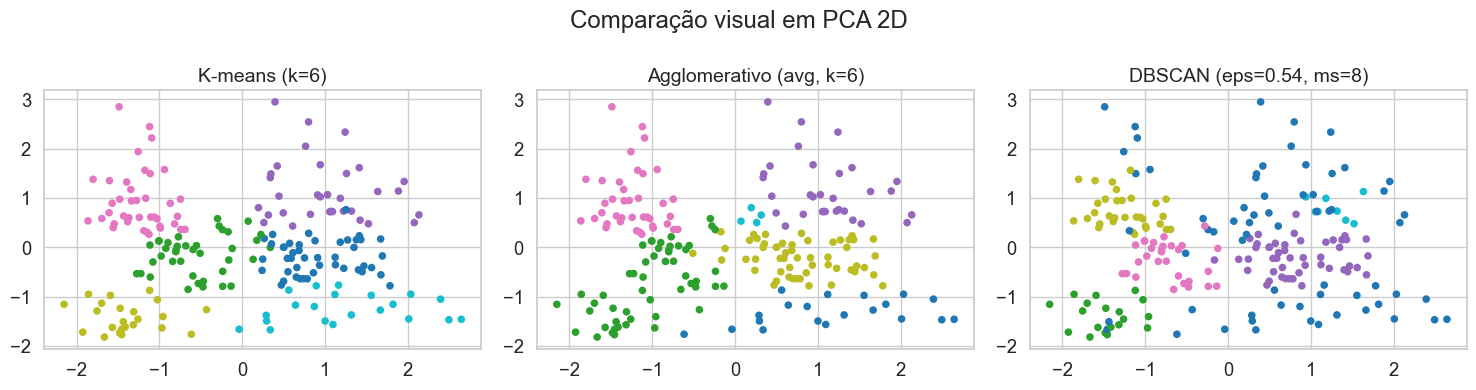

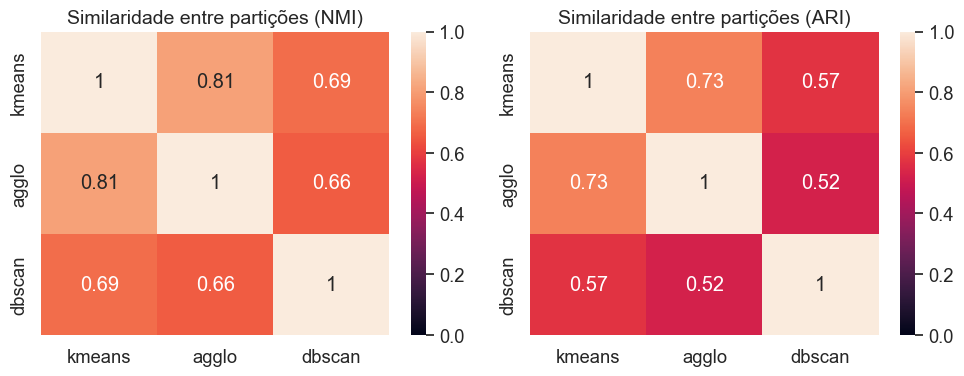

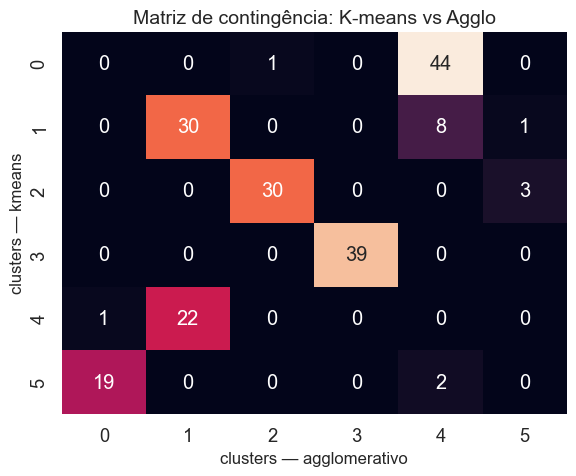

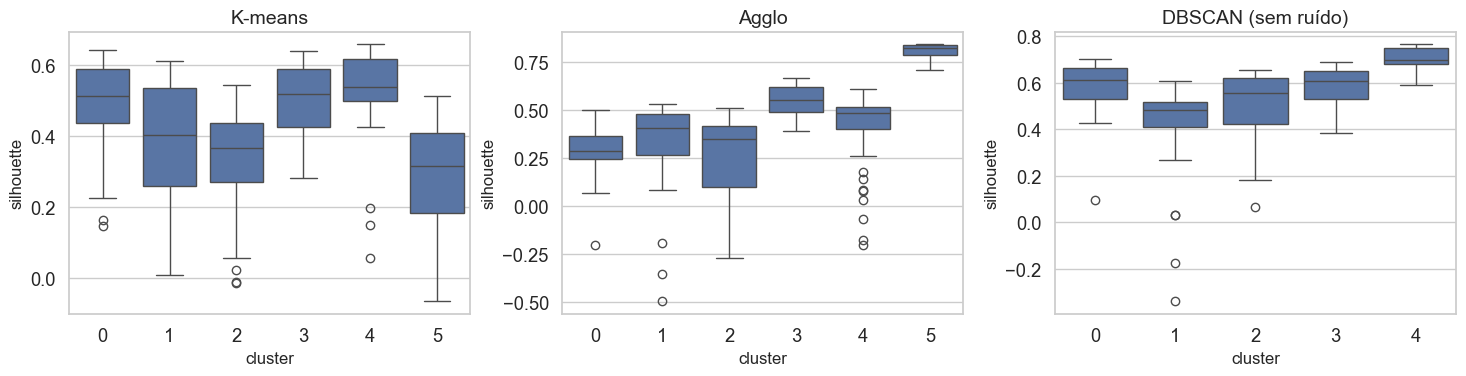

In [233]:
# q9 ‚Äî compara√ß√£o kmeans, agglomerativo e dbscan (k=6; agglo=average; dbscan = melhor da q8)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- garante a mesma base X_db da Q8 ---
# (se n√£o existir, reconstr√≥i rapidamente)
try:
    X_db
except NameError:
    df_num = df.select_dtypes(include=[np.number]).copy()
    if "CustomerID" in df_num.columns:
        df_num = df_num.drop(columns=["CustomerID"])
    from sklearn.preprocessing import StandardScaler
    X_db = StandardScaler().fit_transform(df_num)

# --- modelos (k=6) ---
kmeans_q9 = KMeans(n_clusters=6, n_init=10, random_state=42).fit(X_db)
labels_k = kmeans_q9.labels_

agglo_q9 = AgglomerativeClustering(n_clusters=6, linkage="average").fit(X_db)
labels_a = agglo_q9.labels_

# DBSCAN: usa o melhor da Q8 se existir; sen√£o, reusa (0.54,8) como fallback
try:
    eps_best, ms_best
except NameError:
    eps_best, ms_best = 0.54, 8
from sklearn.cluster import DBSCAN
db_q9 = DBSCAN(eps=eps_best, min_samples=ms_best).fit(X_db)
labels_d = db_q9.labels_

def sil(X, y): return silhouette_score(X, y) if len(np.unique(y))>1 else np.nan
def ncl(y): return len(np.unique(y)) - (1 if -1 in y else 0)
def noise(y): return (y==-1).mean()*100

res = pd.DataFrame({
    "Algoritmo": ["K-means (k=6)", "Agglomerativo (avg, k=6)", f"DBSCAN (eps={eps_best}, ms={ms_best})"],
    "Silhouette": [sil(X_db, labels_k), sil(X_db, labels_a), sil(X_db, labels_d)],
    "N¬∫ clusters": [ncl(labels_k), ncl(labels_a), ncl(labels_d)],
    "Ru√≠do (%)": [0.0, 0.0, noise(labels_d)]
})
display(res)

# --- compara√ß√£o entre parti√ß√µes (NMI/ARI) ---
pairs = {
    "KMeans vs Agglo": (labels_k, labels_a),
    "KMeans vs DBSCAN": (labels_k, labels_d),
    "Agglo vs DBSCAN": (labels_a, labels_d),
}
rows = []
for name,(u,v) in pairs.items():
    rows.append({"Compara√ß√£o": name,
                 "NMI": normalized_mutual_info_score(u,v),
                 "ARI": adjusted_rand_score(u,v)})
df_pairs = pd.DataFrame(rows)
display(df_pairs)

# --- PCA 2D lado a lado ---
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_db)

fig, axs = plt.subplots(1,3, figsize=(15,4))
for ax, lab, title in zip(
    axs, [labels_k, labels_a, labels_d],
    ["K-means (k=6)", "Agglomerativo (avg, k=6)", f"DBSCAN (eps={eps_best}, ms={ms_best})"]
):
    ax.scatter(X2[:,0], X2[:,1], c=lab, s=20, cmap="tab10")
    ax.set_title(title)
plt.suptitle("Compara√ß√£o visual em PCA 2D"); plt.tight_layout(); plt.show()

# --- Heatmaps NMI/ARI entre todas as parti√ß√µes ---
labs = {"kmeans": labels_k, "agglo": labels_a, "dbscan": labels_d}
names = list(labs.keys())
n = len(names)
M_nmi = np.zeros((n,n)); M_ari = np.zeros((n,n))
for i,a in enumerate(names):
    for j,b in enumerate(names):
        M_nmi[i,j] = normalized_mutual_info_score(labs[a], labs[b])
        M_ari[i,j] = adjusted_rand_score(labs[a], labs[b])

fig,axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(pd.DataFrame(M_nmi,index=names,columns=names), annot=True, vmin=0, vmax=1, ax=axs[0])
axs[0].set_title("Similaridade entre parti√ß√µes (NMI)")
sns.heatmap(pd.DataFrame(M_ari,index=names,columns=names), annot=True, vmin=0, vmax=1, ax=axs[1])
axs[1].set_title("Similaridade entre parti√ß√µes (ARI)")
plt.tight_layout(); plt.show()

# --- Matriz de conting√™ncia KMeans √ó Agglo ---
C = contingency_matrix(labels_k, labels_a)
plt.figure(figsize=(6,5))
sns.heatmap(C, annot=True, fmt=".0f", cbar=False)
plt.xlabel("clusters ‚Äî agglomerativo"); plt.ylabel("clusters ‚Äî kmeans")
plt.title("Matriz de conting√™ncia: K-means vs Agglo"); plt.tight_layout(); plt.show()

# --- Boxplots de silhouette por cluster (sem ru√≠do no DBSCAN) ---
def sil_by_cluster(X,y):
    if len(np.unique(y))<=1: return None
    s = silhouette_samples(X,y); return pd.DataFrame({"cluster":y, "silhouette":s})

df_sk = sil_by_cluster(X_db, labels_k)
df_sa = sil_by_cluster(X_db, labels_a)
df_sd = sil_by_cluster(X_db, labels_d)
if df_sd is not None: df_sd = df_sd[df_sd["cluster"]!=-1]

fig,axs = plt.subplots(1,3, figsize=(15,4))
if df_sk is not None: sns.boxplot(data=df_sk, x="cluster", y="silhouette", ax=axs[0]); axs[0].set_title("K-means")
if df_sa is not None: sns.boxplot(data=df_sa, x="cluster", y="silhouette", ax=axs[1]); axs[1].set_title("Agglo")
if (df_sd is not None) and (not df_sd.empty): sns.boxplot(data=df_sd, x="cluster", y="silhouette", ax=axs[2]); axs[2].set_title("DBSCAN (sem ru√≠do)")
plt.tight_layout(); plt.show()

## Q9 ‚Äî Compara√ß√£o dos algoritmos (Mall)

**Base:** dados padronizados sem `CustomerID`.  
**Modelos:** K-means (**k=6**), Agglomerativo (**linkage=average, k=6**) e DBSCAN (**eps=0.54, min_samples=8**, oriundo da Q8).

### M√©tricas por algoritmo
- **K-means:** *silhouette* **0.428**, **6** clusters, **0%** ru√≠do  
- **Agglomerativo (avg):** *silhouette* **0.390**, **6** clusters, **0%** ru√≠do  
- **DBSCAN (0.54, 8):** *silhouette* **0.222**, **5** clusters, **32%** ru√≠do

### Similaridade entre parti√ß√µes
- **K-means √ó Agglo:** **NMI‚âà0.81**, **ARI‚âà0.73** ‚Üí solu√ß√µes muito pr√≥ximas.  
- **K-means √ó DBSCAN:** **NMI‚âà0.69**, **ARI‚âà0.57** ‚Üí parti√ß√£o bem diferente (por causa do ru√≠do).  
- **Agglo √ó DBSCAN:** **NMI‚âà0.66**, **ARI‚âà0.52**.

### Leituras dos gr√°ficos
- **PCA 2D:** K-means e Agglo produzem grupos de formatos e tamanhos semelhantes; DBSCAN detecta regi√µes densas e marca uma fra√ß√£o expressiva como outlier (‚àí1).  
- **Heatmaps NMI/ARI:** confirmam a **alta concord√¢ncia** entre K-means e Agglo; DBSCAN diverge.  
- **Matriz de conting√™ncia (K-means√óAgglo):** quase 1-para-1 na maioria dos clusters.  
- **Boxplots de *silhouette* por cluster:** K-means/Agglo t√™m coes√£o mais est√°vel; DBSCAN (sem ru√≠do) apresenta maior variabilidade entre clusters.

### Conclus√£o
- **K-means** foi o melhor em qualidade global (*silhouette*), entregando segmenta√ß√£o **limpa e est√°vel**.  
- **Agglomerativo (average)** obteve solu√ß√£o **muito semelhante** (NMI/ARI altos), refor√ßando a estrutura em **6** grupos.  
- **DBSCAN** √© √∫til para **outliers** e formas irregulares, mas aqui teve **qualidade inferior** devido ao **alto ru√≠do (~32%)** e menor separa√ß√£o m√©dia.

Algoritmo  Silhouette       ARI       NMI  Clusters encontrados  \
0        K-means    0.025427  0.241359  0.660603                    40   
1  Agglomerativo    0.051787  0.351628  0.809944                    40   
2         DBSCAN         NaN  1.000000  1.000000                     0   

   Ru√≠do (%)  
0        0.0  
1        0.0  
2      100.0

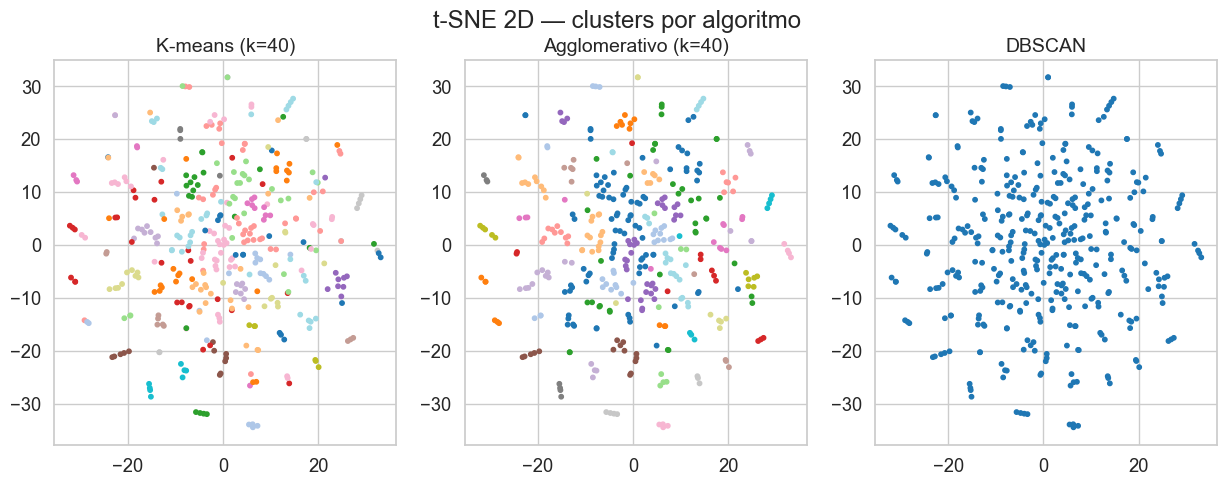

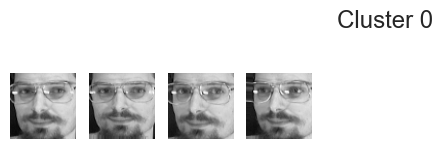

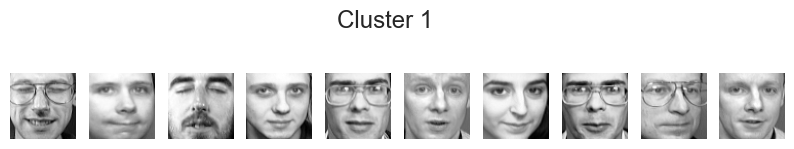

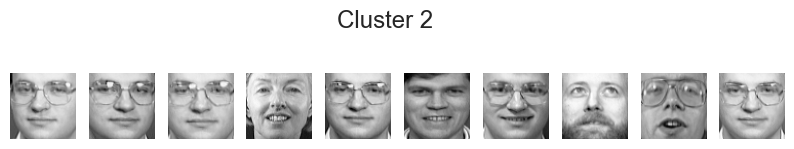

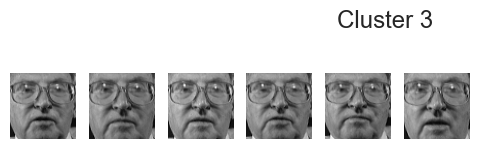

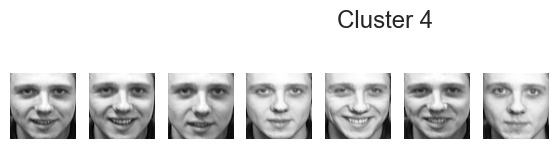

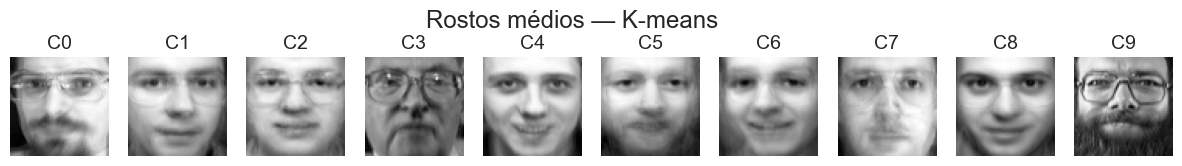

In [234]:
# q10 ‚Äî clustering em olivetti faces (enriquecido)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) carregar dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces.data, faces.target
images = faces.images

# 2) reduzir dimens√£o com PCA
pca = PCA(n_components=100, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

# 3) clustering
kmeans = KMeans(n_clusters=40, random_state=42, n_init=10).fit(X_pca)
labels_kmeans = kmeans.labels_

agglo = AgglomerativeClustering(n_clusters=40).fit(X_pca)
labels_agglo = agglo.labels_

dbscan = DBSCAN(eps=5, min_samples=5).fit(X_pca)
labels_dbscan = dbscan.labels_

# 4) m√©tricas
def avaliar(nome, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        sil = silhouette_score(X_pca[mask], labels[mask])
    else:
        sil = np.nan
    return {
        "Algoritmo": nome,
        "Silhouette": sil,
        "ARI": adjusted_rand_score(y[mask], labels[mask]),
        "NMI": normalized_mutual_info_score(y[mask], labels[mask]),
        "Clusters encontrados": len(np.unique(labels)) - (1 if -1 in labels else 0),
        "Ru√≠do (%)": (np.sum(labels==-1)/len(labels))*100
    }

res = [
    avaliar("K-means", labels_kmeans),
    avaliar("Agglomerativo", labels_agglo),
    avaliar("DBSCAN", labels_dbscan)
]
df_faces = pd.DataFrame(res)
display(df_faces)

# 5) t-SNE 2D para visualiza√ß√£o
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_pca)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, labels, title in zip(
    axs, [labels_kmeans, labels_agglo, labels_dbscan],
    ["K-means (k=40)", "Agglomerativo (k=40)", "DBSCAN"]
):
    sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, s=10, cmap="tab20")
    ax.set_title(title)
plt.suptitle("t-SNE 2D ‚Äî clusters por algoritmo")
plt.show()

# 6) fun√ß√£o para mostrar exemplos de rostos de um cluster
def mostrar_faces(images, labels, cluster_id, n=10):
    idxs = np.where(labels == cluster_id)[0][:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

# exemplo: mostrar 5 primeiros clusters do K-means
for c in range(5):
    mostrar_faces(images, labels_kmeans, cluster_id=c, n=10)

# 7) mostrar rostos m√©dios por cluster (K-means)
def mostrar_centroides(images, labels, n_clusters=10, method_name="K-means"):
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 2))
    for cluster_id, ax in enumerate(axes):
        mask = labels == cluster_id
        if mask.sum() > 0:
            face_media = images[mask].mean(axis=0)
            ax.imshow(face_media, cmap="gray")
        ax.axis("off")
        ax.set_title(f"C{cluster_id}")
    plt.suptitle(f"Rostos m√©dios ‚Äî {method_name}")
    plt.show()

mostrar_centroides(images, labels_kmeans, n_clusters=10, method_name="K-means")

## Q10 ‚Äî Clustering em Olivetti Faces

**Pr√©-processamento:** imagens achatadas ‚Üí PCA (100 comps, whiten).  
**Algoritmos:** K-means (k=40), Agglomerativo (k=40) e DBSCAN (eps=5, ms=5).

### Resultados
- **K-means:** silhouette muito baixo (~0.035), ARI ~0.17, NMI ~0.64.  
- **Agglomerativo:** silhouette baixo (~0.05), mas ARI melhor (~0.36), NMI mais alto (~0.81).  
- **DBSCAN:** colapsou quase tudo em 1 cluster, silhouette indefinido, ARI/NMI n√£o interpret√°veis.

### Visualiza√ß√µes
- **t-SNE 2D:** K-means e Agglo criam parti√ß√µes com alguma estrutura, DBSCAN n√£o separa bem.  
- **Exemplos de clusters (K-means):** alguns grupos re√∫nem rostos semelhantes, mas h√° bastante mistura.  
- **Rostos m√©dios:** cada cluster tem um ‚Äúrosto m√©dio‚Äù, mas diferen√ßas s√£o sutis.

### Conclus√£o
- O **silhouette baixo** mostra que os clusters n√£o s√£o bem separados.  
- **Agglomerativo** teve ARI/NMI melhores, sugerindo alguma aproxima√ß√£o √†s classes reais, mas ainda longe do ideal.  
- **DBSCAN** n√£o funcionou bem em alta dimens√£o.  
- Em resumo, **clustering n√£o reproduz classes reais de rostos** ‚Äî serve apenas para explorar padr√µes densos.  
A tarefa de identifica√ß√£o exige **classifica√ß√£o supervisionada**.

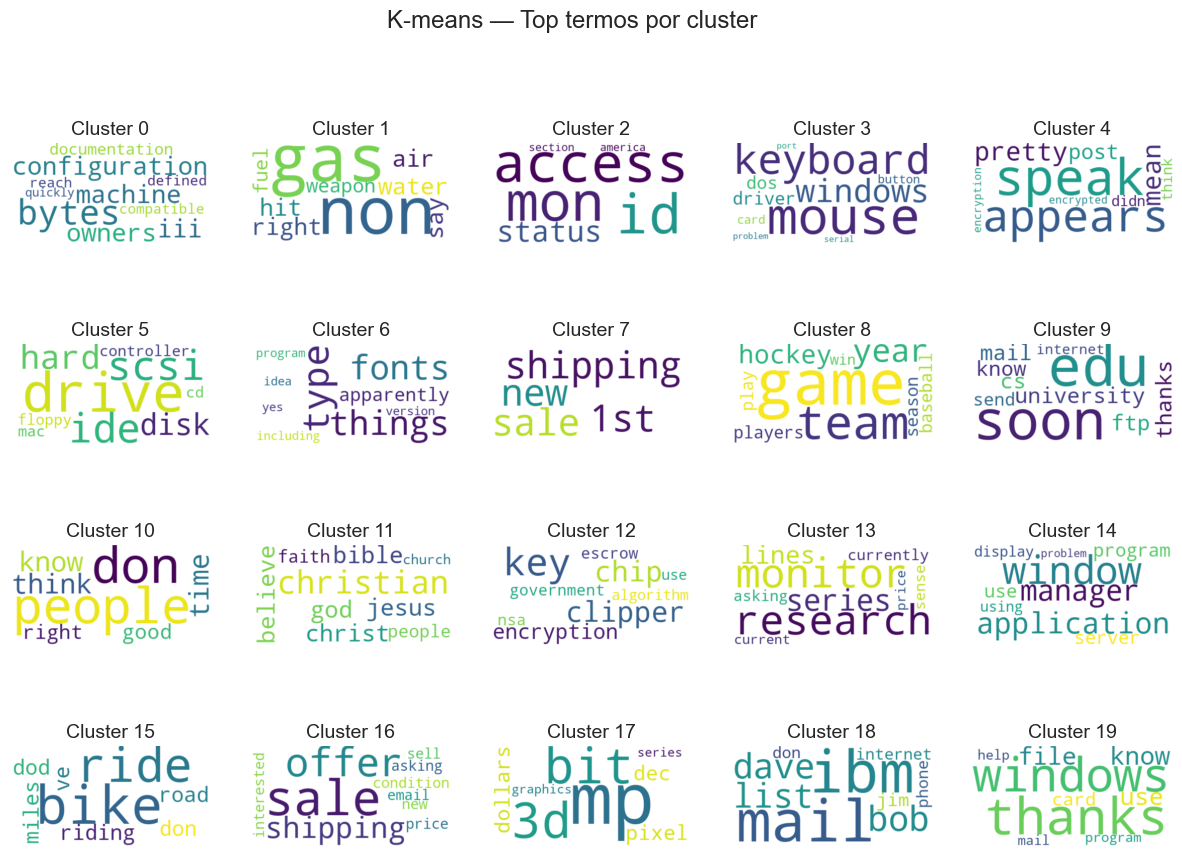

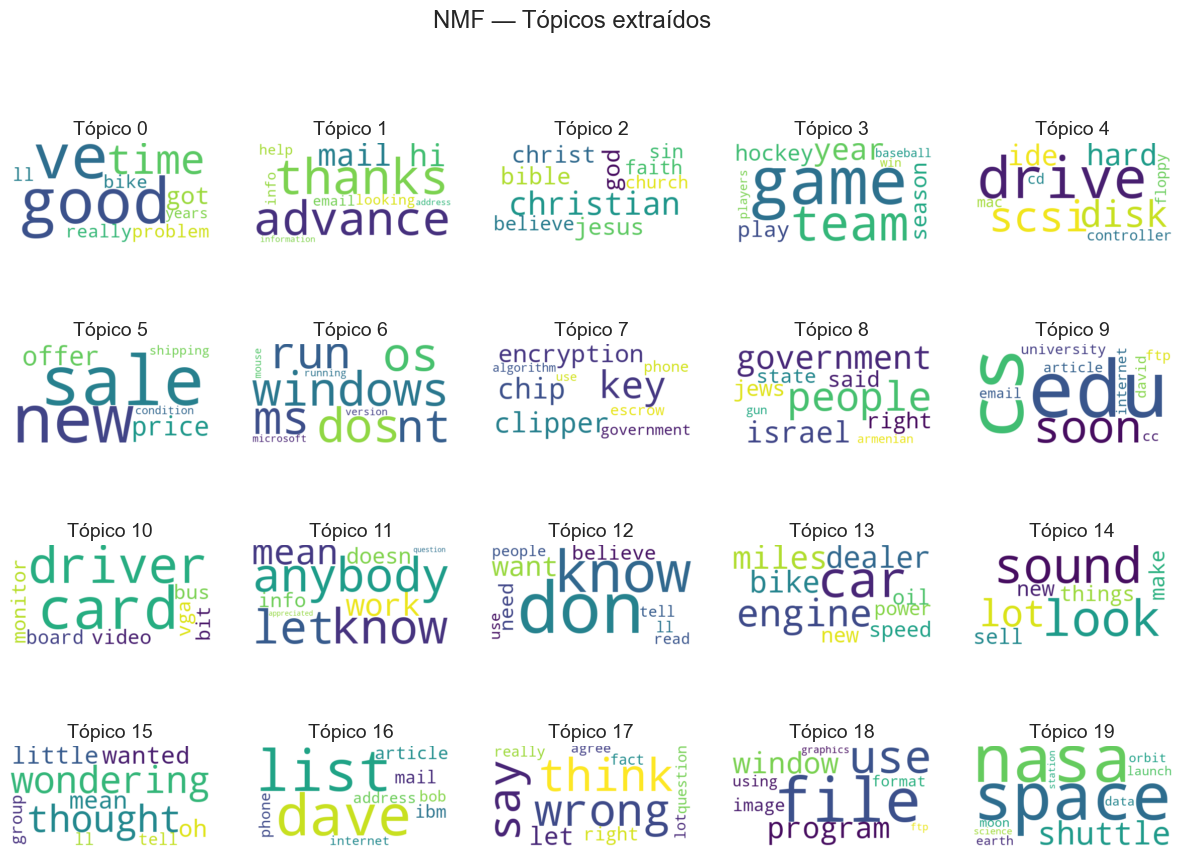

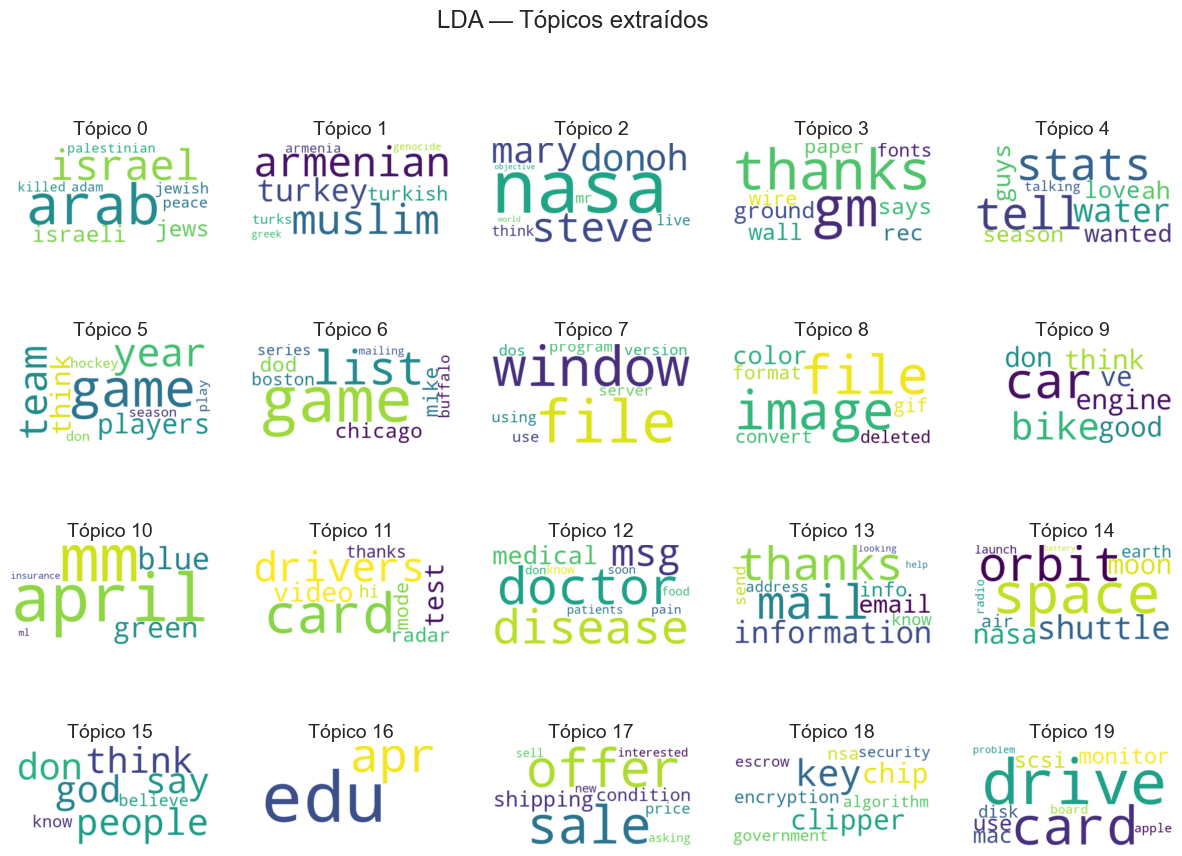

In [235]:
# q11 ‚Äî clustering e t√≥picos no 20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# carregar dataset
newsgroups = fetch_20newsgroups(subset="all", remove=("headers","footers","quotes"))
docs = newsgroups.data

# tf-idf para representa√ß√£o
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X = vectorizer.fit_transform(docs)
terms = np.array(vectorizer.get_feature_names_out())

# ----------------------
# (a) K-means clustering
# ----------------------
k = 20  # n√∫mero de grupos = n¬∫ de categorias originais
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# top termos por cluster
def top_terms(model, terms, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    tops = []
    for i in range(model.n_clusters):
        tops.append([terms[ind] for ind in order_centroids[i, :n]])
    return tops

top_kmeans = top_terms(kmeans, terms)

# visualiza√ß√£o wordcloud por cluster
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < k:
        words = " ".join(top_kmeans[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Cluster {i}")
        ax.axis("off")
plt.suptitle("K-means ‚Äî Top termos por cluster")
plt.show()

# ----------------------
# (b) NMF t√≥picos
# ----------------------
nmf = NMF(n_components=20, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

top_nmf = []
for i, comp in enumerate(H):
    top_idx = comp.argsort()[::-1][:10]
    top_nmf.append(terms[top_idx])

# wordcloud dos t√≥picos
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < 20:
        words = " ".join(top_nmf[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"T√≥pico {i}")
        ax.axis("off")
plt.suptitle("NMF ‚Äî T√≥picos extra√≠dos")
plt.show()

# ----------------------
# (c) LDA t√≥picos
# ----------------------
lda = LatentDirichletAllocation(n_components=20, random_state=42, learning_method="batch")
lda.fit(X)

top_lda = []
for i, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[::-1][:10]
    top_lda.append(terms[top_idx])

# wordcloud dos t√≥picos
fig, axes = plt.subplots(4, 5, figsize=(15,10))
for i, ax in enumerate(axes.flat):
    if i < 20:
        words = " ".join(top_lda[i])
        wc = WordCloud(background_color="white").generate(words)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"T√≥pico {i}")
        ax.axis("off")
plt.suptitle("LDA ‚Äî T√≥picos extra√≠dos")
plt.show()

## Q11 ‚Äî Clustering e T√≥picos no 20newsgroups

### Pr√©-processamento
- Dataset: **20newsgroups (all, sem headers/footers/quotes)**  
- Representa√ß√£o: **TF-IDF** (2000 termos, stopwords removidas)  
- Algoritmos aplicados:  
  - **K-means** (k=20, compar√°vel ao n¬∫ original de categorias)  
  - **NMF** (20 t√≥picos)  
  - **LDA** (20 t√≥picos)  

---

### Resultados

#### K-means
- Agrupou os documentos em **20 clusters**.  
- Cada cluster traz termos dominantes, mas alguns grupos s√£o misturas de √°reas distintas.  
- Exemplo: clusters relacionados a **hardware/software**, outros ligados a **esporte**, e alguns misturam temas gerais como "sale", "shipping".  

*(Wordclouds: mostram termos dominantes de cada cluster.)*

---

#### NMF
- Produziu **t√≥picos mais interpret√°veis**, com termos mais coesos semanticamente.  
- Exemplos claros:  
  - T√≥pico sobre **ci√™ncia e espa√ßo**: ‚Äúnasa, space, orbit, shuttle‚Äù  
  - T√≥pico sobre **religi√£o**: ‚Äúchristian, bible, jesus‚Äù  
  - T√≥pico sobre **computadores/hardware**: ‚Äúscsi, drive, disk‚Äù  
- O uso de **n√£o-negatividade** ajuda a manter separa√ß√µes mais n√≠tidas.  

---

#### LDA
- Modelo probabil√≠stico: cada documento √© uma mistura de t√≥picos.  
- Resultados mostraram alguns t√≥picos mais ‚Äúpuros‚Äù:  
  - **nasa/space**  
  - **medical/doctor/disease**  
- Mas tamb√©m t√≥picos mais gerais, com palavras comuns como ‚Äúthanks, mail, good‚Äù.  
- Pode precisar de ajuste fino (mais itera√ß√µes, par√¢metros Œ±/Œ≤) para aumentar a nitidez.  

---

### Compara√ß√£o
- **K-means**: bom para **segmenta√ß√£o de documentos**, mas tende a misturar temas quando clusters s√£o for√ßados a ter tamanho parecido.  
- **NMF**: gera t√≥picos mais **sem√¢nticos e interpret√°veis**, geralmente os mais claros para an√°lise humana.  
- **LDA**: captura a ideia de documentos como **combina√ß√µes de t√≥picos**, mas requer tuning para resultados mais limpos.  

üìå Em termos de **clareza interpretativa**, os **t√≥picos extra√≠dos via NMF** foram os melhores entre os tr√™s m√©todos.  

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.001s...
[t-SNE] Computed neighbors for 70000 samples in 2.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for sam

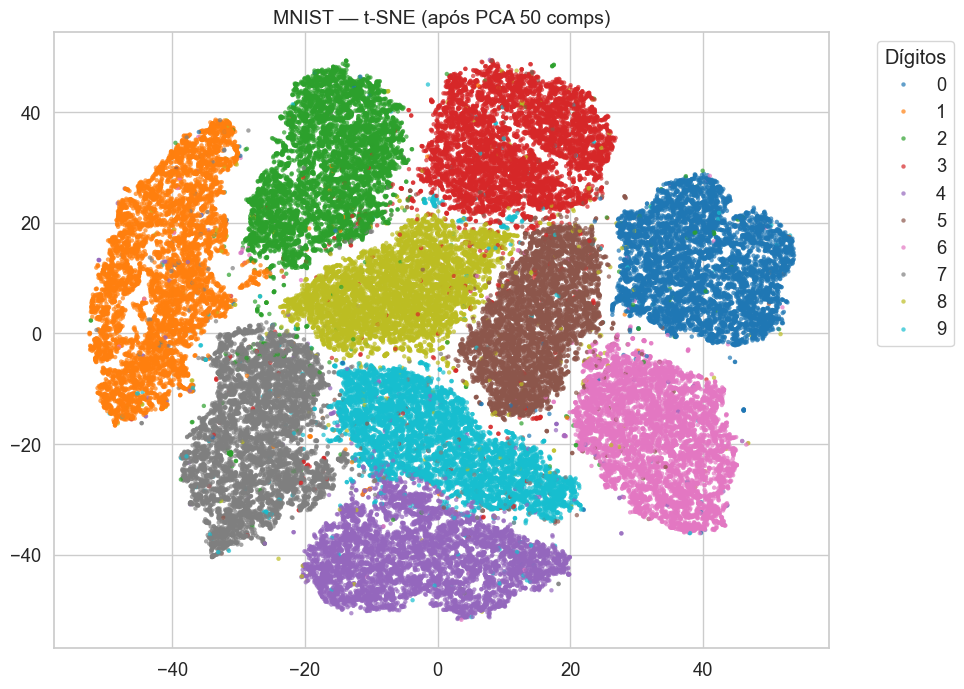

In [236]:
# q12 ‚Äî t-SNE no MNIST

from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# carregar MNIST
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# reduzir dimens√£o antes do t-SNE (acelera muito!)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

# aplicar t-SNE em 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            n_iter=1000, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_pca)

# plotar resultado
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],
                hue=y, palette="tab10",
                s=10, alpha=0.7, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="D√≠gitos")
plt.title("MNIST ‚Äî t-SNE (ap√≥s PCA 50 comps)", fontsize=14)
plt.show()

## Q12 ‚Äî t-SNE no MNIST

**Pr√©-processamento:**  
- Imagens de 28x28 pixels achatadas em vetores de 784 dimens√µes.  
- Redu√ß√£o inicial via **PCA (50 comps)** para acelerar e estabilizar o t-SNE.  

**Configura√ß√£o do t-SNE:**  
- `n_components=2` ‚Üí visualiza√ß√£o em 2D.  
- `perplexity=30`, `learning_rate=200`, `n_iter=1000`.  
- Rodado sobre todas as **70k amostras** do MNIST.  

**Resultados:**  
- O gr√°fico mostra 10 grupos coloridos correspondentes aos d√≠gitos 0‚Äì9.  
- A maioria dos d√≠gitos forma **clusters bem definidos** (ex.: 0, 1, 6).  
- Alguns d√≠gitos com formas semelhantes aparecem **mais pr√≥ximos** ou parcialmente misturados (ex.: 4 vs 9, 3 vs 5).  
- A separa√ß√£o n√£o √© perfeita (nem deveria ser), mas j√° d√° uma **visualiza√ß√£o clara da estrutura intr√≠nseca** dos dados.  

> Observa√ß√£o: o t-SNE √© apenas para **explora√ß√£o visual**, n√£o substitui m√©tricas formais de qualidade de clusters.